**Step 1:** Install libraries and imports

In [1]:
# sqlite3 is built-in; no need to install it
!pip install -q pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

print("Libraries ready!")


Libraries ready!


**Step 2:** Generate synthetic customer data

In [9]:
# Step 1: Create synthetic customer data

np.random.seed(42)

def make_data(n=5000):
    rows = []
    for cid in range(1, n + 1):
        age = np.random.randint(18, 80)
        gender = np.random.choice(["Male", "Female"])
        tenure = np.random.randint(0, 72)
        monthly = round(np.random.uniform(20, 120), 2)
        total = round(monthly * tenure, 2)

        contract = np.random.choice(
            ["Month-to-month", "One year", "Two year"],
            p=[0.5, 0.3, 0.2]
        )
        internet = np.random.choice(
            ["DSL", "Fiber optic", "No"],
            p=[0.35, 0.45, 0.2]
        )
        support_calls = np.random.poisson(2)
        late_pay = np.random.poisson(1)

        # simple churn probability rules
        p = 0.10
        if tenure < 6:
            p += 0.30
        elif tenure < 12:
            p += 0.15
        if contract == "Month-to-month":
            p += 0.25
        if monthly > 80:
            p += 0.15
        if support_calls > 3:
            p += 0.10
        if late_pay > 2:
            p += 0.10
        p = max(0.05, min(0.95, p))
        churn = int(np.random.rand() < p)

        rows.append({
            "customer_id": cid,
            "age": age,
            "gender": gender,
            "tenure_months": tenure,
            "monthly_charges": monthly,
            "total_charges": total,
            "contract_type": contract,
            "internet_service": internet,
            "num_support_calls": support_calls,
            "num_late_payments": late_pay,
            "churn": churn
        })
    return pd.DataFrame(rows)

df = make_data(5000)
print("Rows:", len(df), "| Churn rate:", round(df["churn"].mean(), 3))
df.head()


Rows: 5000 | Churn rate: 0.333


,customer_id,age,gender,tenure_months,monthly_charges,total_charges,contract_type,internet_service,num_support_calls,num_late_payments,churn
0,1,56,Female,14,93.20,1304.80,One year,DSL,1,3,0
1,2,61,Female,37,20.08,742.96,Two year,Fiber optic,1,0,0
2,3,59,Female,59,56.64,3341.76,Month-to-month,Fiber optic,1,1,0
3,4,38,Male,38,21.33,810.54,Two year,Fiber optic,1,0,0
4,5,77,Male,43,69.52,2989.36,Month-to-month,No,2,1,1


Overall churn pie chart

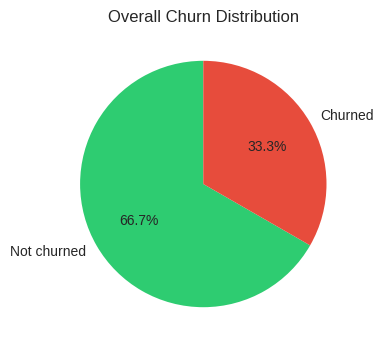

In [10]:
churn_counts = df["churn"].value_counts().sort_index()
labels = ["Not churned", "Churned"]

plt.figure(figsize=(4, 4))
plt.pie(churn_counts, labels=labels, autopct="%1.1f%%",
        colors=["#2ecc71", "#e74c3c"], startangle=90)
plt.title("Overall Churn Distribution")
plt.show()


**Step 3:** Create SQLite DB and Table  

In [11]:
conn = sqlite3.connect("churn.db")
df.to_sql("customers", conn, if_exists="replace", index=False)

summary = pd.read_sql("""
    SELECT COUNT(*) AS total,
           SUM(churn) AS churned,
           ROUND(100.0 * SUM(churn) / COUNT(*), 2) AS churn_rate_pct
    FROM customers;
""", conn)
summary


,total,churned,churn_rate_pct
0,5000,1665,33.3


**Step 4:** Basic SQL EDA

In [12]:
churn_by_contract = pd.read_sql("""
    SELECT contract_type,
           COUNT(*) AS n,
           ROUND(100.0 * SUM(churn) / COUNT(*), 2) AS churn_rate_pct
    FROM customers
    GROUP BY contract_type
    ORDER BY churn_rate_pct DESC;
""", conn)

churn_by_tenure = pd.read_sql("""
    SELECT
        CASE
          WHEN tenure_months < 6 THEN '0-6'
          WHEN tenure_months < 12 THEN '6-12'
          WHEN tenure_months < 24 THEN '12-24'
          ELSE '24+'
        END AS tenure_group,
        COUNT(*) AS n,
        ROUND(100.0 * SUM(churn) / COUNT(*), 2) AS churn_rate_pct
    FROM customers
    GROUP BY tenure_group
    ORDER BY churn_rate_pct DESC;
""", conn)

display(churn_by_contract)
display(churn_by_tenure)


,contract_type,n,churn_rate_pct
0,Month-to-month,2513,44.73
1,Two year,976,21.82
2,One year,1511,21.71


,tenure_group,n,churn_rate_pct
0,0-6,389,56.04
1,6-12,374,43.58
2,24+,3377,30.53
3,12-24,860,29.42


**Step 5:** SQL Analysis: Churn by contract and tenure

In [13]:
# Step 3: Some SQL analysis

churn_by_contract = pd.read_sql("""
    SELECT contract_type,
           COUNT(*) AS n,
           ROUND(100.0 * SUM(churn) / COUNT(*), 2) AS churn_rate_pct
    FROM customers
    GROUP BY contract_type
    ORDER BY churn_rate_pct DESC;
""", conn)

churn_by_tenure = pd.read_sql("""
    SELECT
        CASE
          WHEN tenure_months < 6 THEN '0-6'
          WHEN tenure_months < 12 THEN '6-12'
          WHEN tenure_months < 24 THEN '12-24'
          ELSE '24+'
        END AS tenure_group,
        COUNT(*) AS n,
        ROUND(100.0 * SUM(churn) / COUNT(*), 2) AS churn_rate_pct
    FROM customers
    GROUP BY tenure_group
    ORDER BY churn_rate_pct DESC;
""", conn)

display(churn_by_contract)
display(churn_by_tenure)


,contract_type,n,churn_rate_pct
0,Month-to-month,2513,44.73
1,Two year,976,21.82
2,One year,1511,21.71


,tenure_group,n,churn_rate_pct
0,0-6,389,56.04
1,6-12,374,43.58
2,24+,3377,30.53
3,12-24,860,29.42


Plots for SQL Analysis

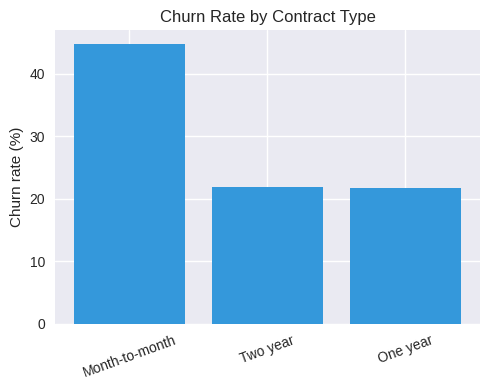

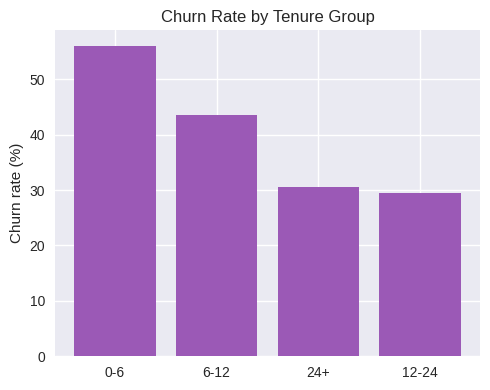

In [14]:
# Plot for Churn rate by contract type

plt.figure(figsize=(5, 4))
plt.bar(churn_by_contract["contract_type"],
        churn_by_contract["churn_rate_pct"],
        color="#3498db")
plt.ylabel("Churn rate (%)")
plt.title("Churn Rate by Contract Type")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Plot for Churn rate by tenure group

plt.figure(figsize=(5, 4))
plt.bar(churn_by_tenure["tenure_group"],
        churn_by_tenure["churn_rate_pct"],
        color="#9b59b6")
plt.ylabel("Churn rate (%)")
plt.title("Churn Rate by Tenure Group")
plt.tight_layout()
plt.show()


Monthly charges vs churn plot

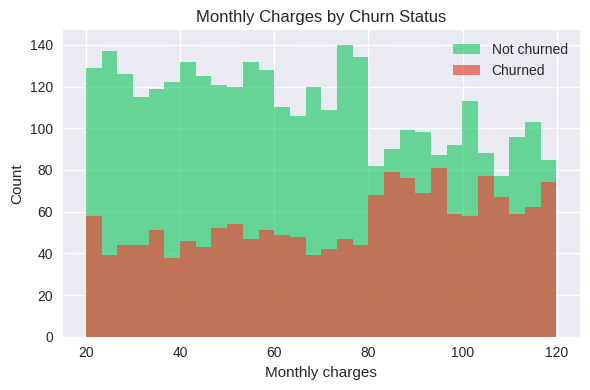

In [15]:
plt.figure(figsize=(6, 4))
plt.hist(
    df[df["churn"] == 0]["monthly_charges"],
    bins=30, alpha=0.7, label="Not churned", color="#2ecc71"
)
plt.hist(
    df[df["churn"] == 1]["monthly_charges"],
    bins=30, alpha=0.7, label="Churned", color="#e74c3c"
)
plt.xlabel("Monthly charges")
plt.ylabel("Count")
plt.title("Monthly Charges by Churn Status")
plt.legend()
plt.tight_layout()
plt.show()


**Step 6:** Feature Engineering with SQL

In [16]:
features = pd.read_sql("""
    SELECT
        customer_id,
        age,
        tenure_months,
        monthly_charges,
        num_support_calls,
        num_late_payments,
        CASE WHEN tenure_months = 0 THEN 0
             ELSE total_charges / tenure_months END AS avg_monthly_spend,
        CASE WHEN gender = 'Male' THEN 1 ELSE 0 END AS gender_male,
        CASE WHEN contract_type = 'Month-to-month' THEN 1 ELSE 0 END AS contract_monthly,
        CASE WHEN contract_type = 'One year' THEN 1 ELSE 0 END AS contract_one_year,
        CASE WHEN contract_type = 'Two year' THEN 1 ELSE 0 END AS contract_two_year,
        churn AS label
    FROM customers;
""", conn)

print("Feature table shape:", features.shape)
features.head()

Feature table shape: (5000, 12)


,customer_id,age,tenure_months,monthly_charges,num_support_calls,num_late_payments,avg_monthly_spend,gender_male,contract_monthly,contract_one_year,contract_two_year,label
0,1,56,14,93.20,1,3,93.20,0,0,1,0,0
1,2,61,37,20.08,1,0,20.08,0,0,0,1,0
2,3,59,59,56.64,1,1,56.64,0,1,0,0,0
3,4,38,38,21.33,1,0,21.33,1,0,0,1,0
4,5,77,43,69.52,2,1,69.52,1,1,0,0,1


**Step 7:** Train/Test split and model training

In [18]:
train = features[features["customer_id"] % 5 != 0]
test  = features[features["customer_id"] % 5 == 0]

X_cols = [c for c in features.columns if c not in ["customer_id", "label"]]
X_train, y_train = train[X_cols], train["label"]
X_test, y_test   = test[X_cols], test["label"]

lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

print("Models trained.")


Models trained.


**Step 8:** Evaluation and confusion matrix

In [20]:
def evaluate(model, name):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    print(f"\n{name}")
    print("-" * len(name))
    print(f"accuracy = {acc:.3f}, precision = {prec:.3f}, recall = {rec:.3f}")
    print(classification_report(y_test, preds))

print("Model performance:")
evaluate(lr, "Logistic Regression")
evaluate(rf, "Random Forest")

# Confusion matrix for best model (Random Forest)
rf_preds = rf.predict(X_test)
cm = confusion_matrix(y_test, rf_preds)

cm_df = pd.DataFrame(
    cm,
    index=["Actual: Not churn", "Actual: Churn"],
    columns=["Predicted: Not churn", "Predicted: Churn"]
)
cm_df


Model performance:

Logistic Regression
-------------------
accuracy = 0.690, precision = 0.500, recall = 0.255
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       690
           1       0.50      0.25      0.34       310

    accuracy                           0.69      1000
   macro avg       0.61      0.57      0.57      1000
weighted avg       0.66      0.69      0.66      1000


Random Forest
-------------
accuracy = 0.692, precision = 0.505, recall = 0.342
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       690
           1       0.50      0.34      0.41       310

    accuracy                           0.69      1000
   macro avg       0.62      0.60      0.60      1000
weighted avg       0.67      0.69      0.67      1000



,Predicted: Not churn,Predicted: Churn
Actual: Not churn,586,104
Actual: Churn,204,106


Feature importance plot

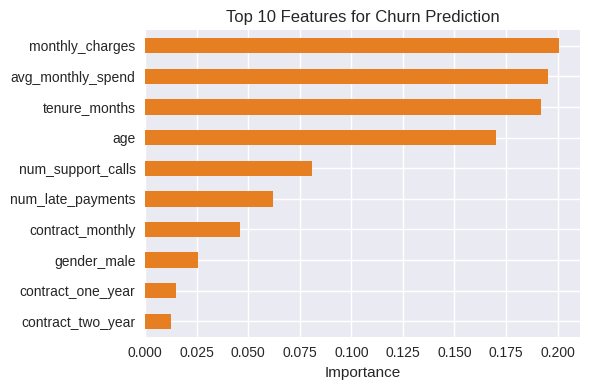

In [21]:
importances = pd.Series(rf.feature_importances_, index=X_cols)
top_imp = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(6, 4))
top_imp.plot(kind="barh", color="#e67e22")
plt.xlabel("Importance")
plt.title("Top 10 Features for Churn Prediction")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [22]:
#Save artifacts

df.to_csv("customer_data.csv", index=False)
features.to_csv("features_table.csv", index=False)

plt.figure(figsize=(6, 4))
top_imp.plot(kind="barh", color="#e67e22")
plt.xlabel("Importance")
plt.title("Top 10 Features for Churn Prediction")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()

print("Saved:")
print("- churn.db (SQLite database)")
print("- customer_data.csv")
print("- features_table.csv")
print("- feature_importance.png")


Saved:
- churn.db (SQLite database)
- customer_data.csv
- features_table.csv
- feature_importance.png
